# Expectation Maximisation for Parameter Estimation of a Gaussian Mixture Model
In this notebook we will fit the Old Faithful geyser data set using the Expectation Maximisation algorithm to a mixture of two Gaussian distributions. This will basically will be a soft clustering. 

In [624]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [625]:
# lets download the old faithful dataset from CMU website
# the data is avalable as .dat file
# and load it into a pandas dataframe
url = 'https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv'
# the dataset is tab separated
df = pd.read_csv(url, sep='\t')
df.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


We will normalise the data, we have already discussed this in the previous notebook the possible ways and benifits of normalising the data. 

In [626]:
# lets normalize the data
df = (df - df.mean()) / df.std()

## EM algorithm
We have preffered to create a class for EM to better manage the parameters and the functions. We have also preffered the general more intutitive approach rather than vectorised code, for better understansing of whats actually going on. Our implementation is inspired by the definitions ans methods from the book by Christopher M. Bishop. Please refer section 9.2 page 430 431 and 432 of the same.

In [627]:
class EM:
    def __init__(self):
        self.MuList = None
        self.SigmaList = None
        self.PiList = None
        self.K = None
        self.data = None
        self.maxIter = None
        self.threshold = None
        self.iter = None
        self.logLikelihood = None
        self.iterationData = {'MuList' : [], 'SigmaList' : [], 'PiList' : [], 'logLikelihood' : []}

        
    def gaussian_pdf(self, X, Mu, Sigma):
        """
        Calculates the probability density function of a multivariate Gaussian distribution.
        :param X: Data point
        :param Mu: Mean
        :param Sigma: Covariance matrix
        :return: Probability density function
        """
        return (2 * math.pi) ** (-X.shape[0] / 2) * (np.linalg.det(Sigma) ** -0.5) * np.exp(-0.5 * np.dot(np.dot((X - Mu), np.linalg.inv(Sigma)), (X - Mu).T))

    def fit(self, X, K, maxIter=100, threshold=1e-5):
        # define initial parameters
        self.K = K
        self.data = X
        self.maxIter = maxIter
        self.threshold = threshold
        self.iter = 0
        self.logLikelihood = []
        # initialize parameters
        # self.MuList = np.array([np.random.rand(self.data.shape[1]) for i in range(self.K)])
        self.MuList = np.array([[-2,2],[2,-2]])
        self.SigmaList = np.random.rand(self.K, X.shape[1], X.shape[1])
        self.PiList = np.random.rand(self.K)
        self.PiList = self.PiList / np.sum(self.PiList)
        
        # initalise sigma to Is
        for i in range(self.K):
            self.SigmaList[i] = np.identity(X.shape[1])
        
        # run EM algorithm
        while self.iter < self.maxIter:
            print(":",end="")
            self.iter += 1
            newMuList = np.array([self.update_mu_k(k) for k in range(self.K)])
            newSigmaList = np.array([self.update_sigma_k(k) for k in range(self.K)])
            newPiList = np.array([self.update_pi_k(k) for k in range(self.K)])
            # update Mus
            for k in range(self.K):
                newMuList[k] = self.update_mu_k(k)
            # update Sigmas
            for k in range(self.K):
                newSigmaList[k] = self.update_sigma_k(k)
            # update Pis
            for k in range(self.K):
                newPiList[k] = self.update_pi_k(k)

            # update parameters
            self.MuList = newMuList
            self.SigmaList = newSigmaList
            self.PiList = newPiList
            
            # update log likelihood
            self.logLikelihood.append(self.calculate_log_likelihood())
            
            self.iterationData['MuList'].append(self.MuList)
            self.iterationData['SigmaList'].append(self.SigmaList)
            self.iterationData['PiList'].append(self.PiList)
            self.iterationData['logLikelihood'].append(self.logLikelihood[-1])
            # check convergence
            if self.iter > 1:
                if np.abs(self.logLikelihood[-1] - self.logLikelihood[-2]) < self.threshold:
                    break
    
        
    def update_mu_k(self, k):
        """
        Updates the mean of the kth Gaussian distribution.
        :param k: Index of the Gaussian distribution
        :return: Updated mean
        """
        new_mu = np.zeros(self.data.shape[1])
        for i in range(self.data.shape[0]):
            new_mu += self.gamma_nk(i, k) * self.data[i]
        new_mu /= self.N_k(k)
        return new_mu

    def update_sigma_k(self, k):
        new_sigma = np.zeros((self.data.shape[1], self.data.shape[1]))
        for i in range(self.data.shape[0]):
            gamma = self.gamma_nk(i, k)
            x = self.data[i]
            new_sigma += gamma * np.outer((x - self.MuList[k]), (x - self.MuList[k]))
            assert new_sigma[0][1] == new_sigma[1][0]
        new_sigma /= self.N_k(k)
        return new_sigma

    def update_pi_k(self, k):
        return self.N_k(k) / self.data.shape[0]

    
    def gamma_nk(self, n, k):
        """
        Calculates the posterior probability of the nth data point belonging to the kth Gaussian distribution.
        :param n: Index of the data point
        :param k: Index of the Gaussian distribution
        :return: Posterior probability
        """
        numerator = self.PiList[k] * self.gaussian_pdf(self.data[n], self.MuList[k], self.SigmaList[k])
        denominator = np.sum (np.array([self.PiList[i] * self.gaussian_pdf(self.data[n], self.MuList[i], self.SigmaList[i]) for i in range(self.K)]))
        return numerator / denominator

    def N_k(self, k):
        """
        Calculates the number of data points belonging to the kth Gaussian distribution.
        :param k: Index of the Gaussian distribution
        :return: Number of data points
        """
        return np.sum(np.array([self.gamma_nk(n, k) for n in range(self.data.shape[0])]))

    def calculate_log_likelihood(self):
        """
        Calculates the log likelihood of the data given the current parameters.
        :return: Log likelihood
        """
        return np.sum(np.array([np.log(np.sum(np.array([self.PiList[i] * self.gaussian_pdf(self.data[n], self.MuList[i], self.SigmaList[i]) for i in range(self.K)]))) for n in range(self.data.shape[0])]))


In [628]:
em = EM()
em.fit(df.values, 2, maxIter=1000, threshold=1e-5)

::::::::::::::::::::::::::::

### Estimating the parameters
So we ran the EM algo for the old Faithful geyser data set, and now will store the learned parameters for visualisation and plots.

In [629]:
Mus = em.iterationData['MuList']
Sigmas = em.iterationData['SigmaList']
Pis = em.iterationData['PiList']
# create a df of means


Once after estimating the parameters, we will calculate the probability for each data point to belong to each of the two clusters. We will use this probability to plot the the data points.

In [630]:
# get probabilites for each data point to belong to each cluster
probabilities = np.zeros((df.shape[0], em.K))
colors = np.zeros((df.shape[0], 3))
for i in range(df.shape[0]):
    for k in range(em.K):
        probabilities[i, k] = em.PiList[k] * em.gaussian_pdf(df.values[i], em.MuList[k], em.SigmaList[k])
    # normalise probabilities
    probabilities[i] = probabilities[i] / np.sum(probabilities[i])
    # get color
    colors[i] = np.array([probabilities[i, 0], 0, probabilities[i, 1]])  # R and B value are affected by the probability of belonging to the cluster


### Visualising the clusters
Now we will plot the data points and the estimated Gaussian distributions, the color of the points will be the probability of the data point to belong to the first or the second cluster. The probability of first will control the R value of the color, the probability of second will control the B value of the color.

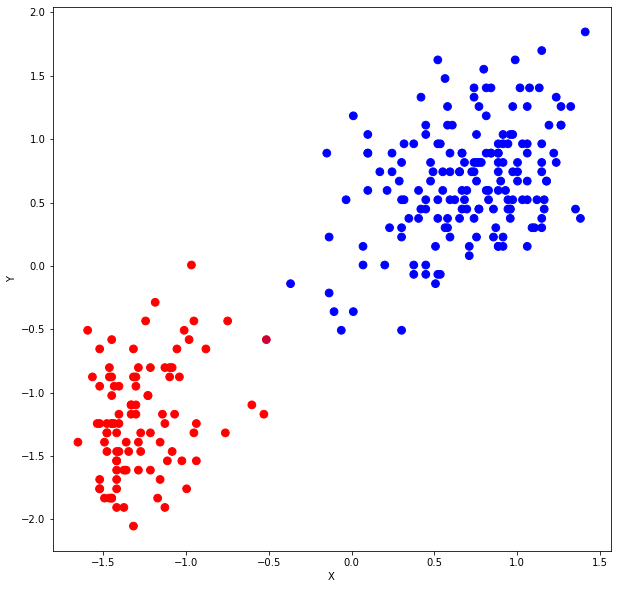

In [631]:
# plot the points with their RGB as a function of the probability of belonging to each cluster
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.values[:, 0], df.values[:, 1], c=colors, s=60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

We can see that there are very few points who have fair share in both the clusters, most of the points are concentrated in one cluster, and are of pure Red or Blue, color.

Now lets add the contours of the two Gaussian distributions on the scatter plot for better understanding, of the distribution.

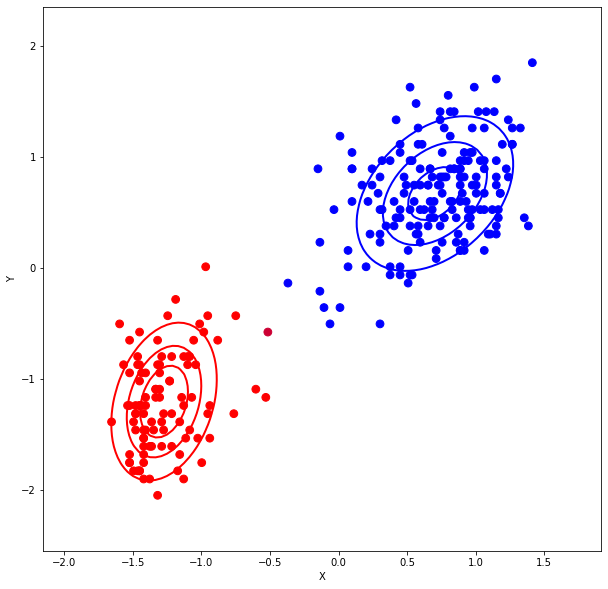

In [632]:
# plot the points with their RGB as a function of the probability of belonging to each cluster
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.values[:, 0], df.values[:, 1], c=colors, s=60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
# plot the countour of the gaussian
x = np.linspace(df.values[:, 0].min() - 0.5, df.values[:, 0].max() + 0.5, 100)
y = np.linspace(df.values[:, 1].min() - 0.5, df.values[:, 1].max() + 0.5, 100)
X, Y = np.meshgrid(x, y)
crs = ['r', 'b']
for k in range(em.K):
    mu = em.MuList[k]
    sigma = em.SigmaList[k]
    Z = [em.gaussian_pdf(np.array([x, y]), mu, sigma)*em.PiList[k] for x, y in zip(np.ravel(X), np.ravel(Y))]
    Z = np.reshape(Z, X.shape)
    ax.contour(X, Y, Z, levels=3, colors=crs[k], linewidths=[2])
plt.show()

### Quality of Clusters
So we can see that the clusters are fairly separated, and the pdfs are fitting the data very nicely, i.e. clusters are not (much) overlapping. Here as it is a probabilistic model, so each point will have a share of both the clusters, but when the shar eof one cluster is insignificant, then we can say the confidence of that point is high, and if this is the case with most of the points then we can say that the clusters are very well separated.

## Visualising EM in action 
We have visualised the final learned parameters, but this would be learnt by varous E and M steps in which new parameters will be estimated and then points will be evaluated based on that. We continue this process untill convergence or when change becomes insignificant.

Convergence can take several iterations, this will vary depending on the data set, and the initial parameters. So we will consider some iterations among all the iterations and will see how clusters have changed.

We will create a similar plot for the iterations, as we did for the final plot. Doing this will be easy because we have saved the parameters for rach iteration already in a list while doing the EM algo.

[ 0  3  6 10 13 16 20 23 27]
9


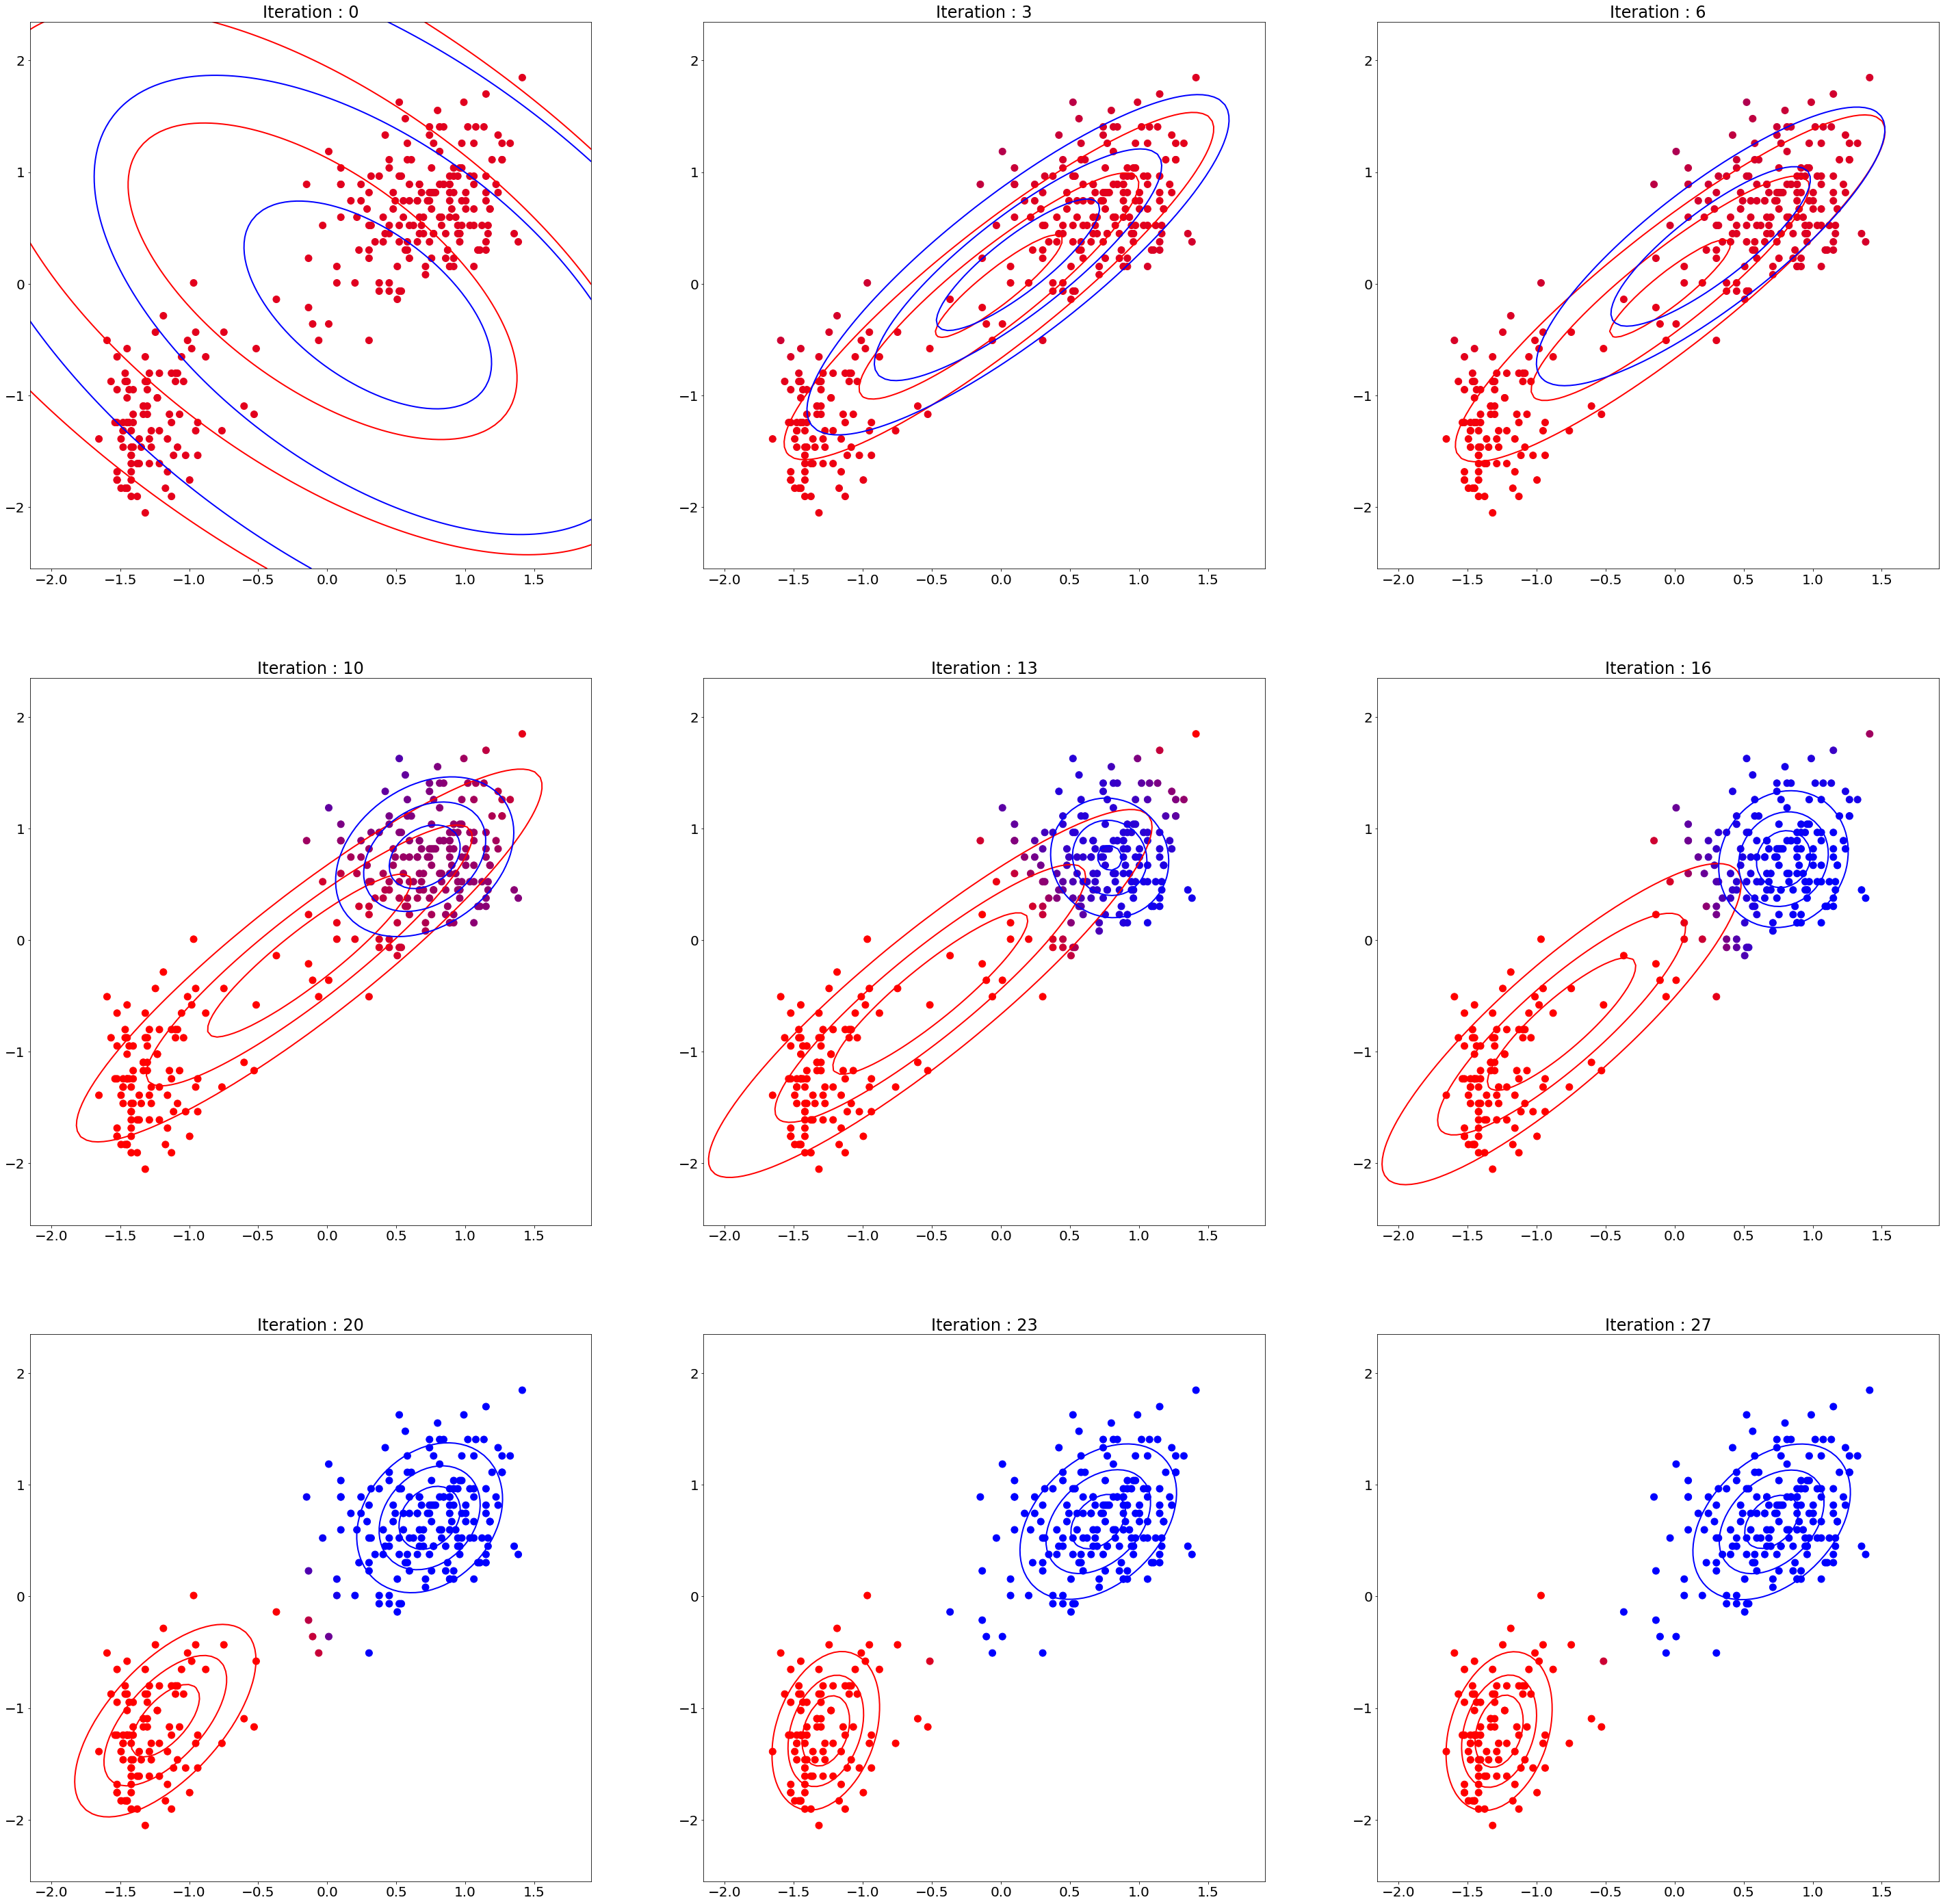

In [637]:
# plot the scatter subplots plot and countours for each iteration

iterationData = em.iterationData
# select 9almost equally spaced points from 0 to the number of iterations
iteration_indices = np.linspace(0, len(iterationData['logLikelihood']) - 1, 9).astype(int)

nPLots = len(iteration_indices)
print(iteration_indices)
print(nPLots)
fig, ax = plt.subplots(3, 3 , figsize=(50, 50))
# increase the text size
plt.rcParams.update({'font.size': 20})
cnt = 0
for it in iteration_indices:
    MuList = iterationData['MuList'][it]
    SigmaList = iterationData['SigmaList'][it]
    PiList = iterationData['PiList'][it]
    probabilities = np.zeros((df.shape[0], em.K))
    colors = np.zeros((df.shape[0], 3))
    for i in range(df.shape[0]):
        for k in range(em.K):
            probabilities[i, k] = PiList[k] * em.gaussian_pdf(df.values[i], MuList[k], SigmaList[k])
        # normalise probabilities
        probabilities[i] = probabilities[i] / np.sum(probabilities[i])
        # get color
        colors[i] = np.array([probabilities[i, 0], 0, probabilities[i, 1]])
    ax[cnt//3, cnt%3].scatter(df.values[:, 0], df.values[:, 1], c=colors, s=100)
    x = np.linspace(df.values[:, 0].min() - 0.5, df.values[:, 0].max() + 0.5, 100)
    y = np.linspace(df.values[:, 1].min() - 0.5, df.values[:, 1].max() + 0.5, 100)
    X, Y = np.meshgrid(x, y)
    crs = ['r', 'b']
    for k in range(em.K):
        mu = MuList[k]
        sigma = SigmaList[k]
        Z = [em.gaussian_pdf(np.array([x, y]), mu, sigma)*PiList[k] for x, y in zip(np.ravel(X), np.ravel(Y))]
        Z = np.reshape(Z, X.shape)
        ax[cnt//3, cnt%3].contour(X, Y, Z, levels=3, colors=crs[k], linewidths=[2])
        ax[cnt//3, cnt%3].set_title('Iteration : ' + str(it))
    cnt += 1
plt.show()


So we can see how the EM steps estimates new parameters and improves with time untill it converges. Also in the initial steps we can also see the confidence of some points are low, i.e. they had fair share of both red and blue.

### Log Likelihood
EM algo is basically the algo to maximise the likelihood of the data, so we can see how the likelihood changes with the iterations. Plotting the likelihood or in our case log likelihood will give us a better idea of how the EM algo is improvin and how and where it is converging.

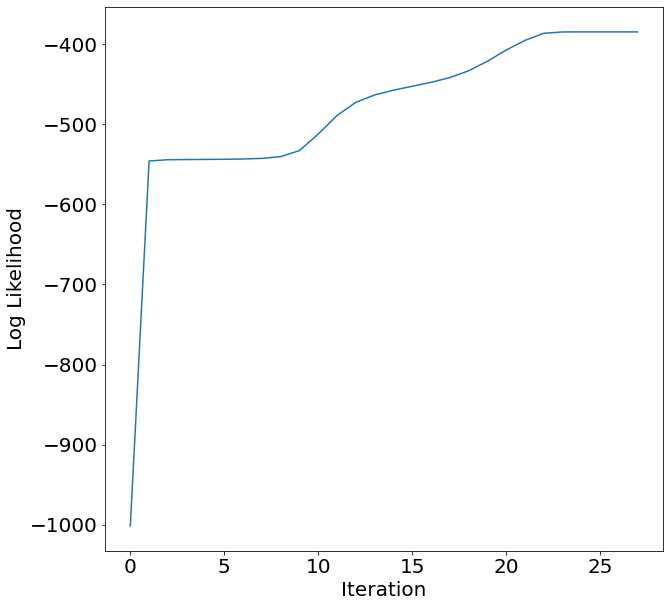

In [638]:
# plotting log likelihood vs iteration
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(iterationData['logLikelihood'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Likelihood')
plt.show()


So we can see that the log likelyhood is very steep at the beginning, and then at end it is almost constant when we achieve convergence.